# Curvas de Accuracy y Mean Distance

En esta notebook, veremos de armar las curvas de geolocalización y mean distance. 

Es decir, para cada modelo entrenado, vamos a ver cuál fue su performance usando las primeras 250, 500, 750, ... , 18.5, 19k, 19.5k palabras (~20% del vocabulario). La performance la vamos a medir de dos maneras:

1. Accuracy (recordemos que es un problema con 23 clases)
2. Mean Distance: la media del error en las distancias. Acá fijamos la distancia entre dos provincias como la distancia entre sus capitales 

El modelo lo entrenamos con MaxEnt/Regresión Logística usando penalidad $L_2$ y $C=1$. Los sets de features son los siguientes: 

1. Information Value sobre palabras
2. Information Value sobre personas 
3. Information Gain Ratio (Han, Cook et al) sobre palabras
4. Information Gain Ratio sobre personas
5. Ordenados por Cantidad de provincias, luego por term-frequency (term-frequency inverse-province frequency, TF-IPF)


Cargamos los resultados ya calculados

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd

dfs = {}

dfs["igr_palabras"] = pd.DataFrame(
    pickle.load(open("res_igr_palabras.pkl", "rb"))
)
dfs["igr_personas"] = pd.DataFrame(
    pickle.load(open("res_igr_personas.pkl", "rb"))
)
dfs["iv_palabras"] = pd.DataFrame(
    pickle.load(open("res_iv_palabras.pkl", "rb")) 
)
dfs["iv_personas"] = pd.DataFrame(
    pickle.load(open("res_iv_personas.pkl", "rb"))
)
dfs["tf_ipf"] = pd.DataFrame(
    pickle.load(open("res_tf_ipf.pkl", "rb"))
)

for key, df in dfs.items():
    df.set_index("num_words", inplace=True)
    df.drop("clf", axis=1, inplace=True)

Hago join de todo esto para poder graficarlo

In [2]:
joined = dfs["igr_palabras"].join(dfs["igr_personas"], lsuffix="_igr_palabras", rsuffix="_igr_personas")
joined = joined.join(dfs["iv_palabras"])
joined = joined.join(dfs["iv_personas"], lsuffix="_iv_palabras", rsuffix="_iv_personas")

joined["accuracy_tf_ipf"] = dfs["tf_ipf"]["accuracy"]
joined["mean_distance_tf_ipf"] = dfs["tf_ipf"]["mean_distance"]


In [3]:
joined.columns

Index(['accuracy_igr_palabras', 'mean_distance_igr_palabras',
       'accuracy_igr_personas', 'mean_distance_igr_personas',
       'accuracy_iv_palabras', 'mean_distance_iv_palabras',
       'accuracy_iv_personas', 'mean_distance_iv_personas', 'accuracy_tf_ipf',
       'mean_distance_tf_ipf'],
      dtype='object')

In [4]:
from contrastes.processing import build_dataframe_from_users
from contrastes.processing import preprocess_raw_df

word_df = pd.read_csv("train_word_df_filtered.csv", index_col=0)
word_df = preprocess_raw_df(word_df, filter_words=(10, 2))

/home/jmperez/projects/contrastes/contrastes/processing.py:185: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_palabras = cant_palabras
/home/jmperez/projects/contrastes/contrastes/processing.py:186: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_personas = cant_personas


In [5]:
word_df.shape

(103782, 55)

## Gráfico de accuracy según cantidad de features usadas

Acá haremos un gráfico de la accuracy (más accuracy es mejor!)

In [6]:
def rename_column(col_name):
    col_name = col_name.replace("mean_distance_", "")
    col_name = col_name.replace("accuracy_", "")
    col_name = col_name.replace("personas", "user")
    col_name = col_name.replace("palabras", "words")
    return col_name

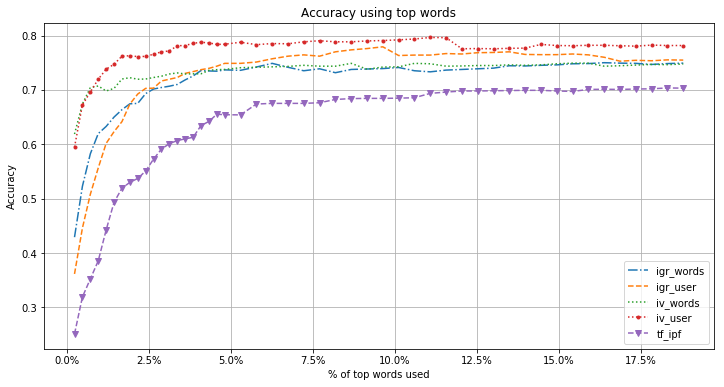

In [7]:
import matplotlib.pyplot as plt

cols = [col for col in joined.columns if "accuracy" in col]
plot_df = joined[cols].copy()

rename = {col: rename_column(col) for col in cols}
plot_df.rename(rename, axis=1, inplace=True)


markers = ["-.", "--", ":", ":.", "--v"]
x = (100 * joined.index / word_df.shape[0])

ax = plot_df.plot(
    x=x,
    title="Accuracy using top words", figsize=(12, 6), grid=True,
    style=markers,
);


ax.set_xlabel("% of top words used")
ax.set_ylabel("Accuracy")
ax.set_xticklabels([str(t)+"%" for t in ax.get_xticks()]);

plt.savefig("../../output/figures/accuracy_comparison.png")

- Vemos que las que mejor funcionan son las dos que usan las features obtenidas sobre las personas!
- IGR termina ganándole cuando usamos 10k palabras (~10% vocabulario) pero con menos prevalece IV. 
- Hay un drop de 12k palabras a 12.5 en IV personas (¿qué pasó ahí?)

## Gráfico de Mean Distance según cantidad de features usadas

Acá haremos un gráfico de la mean distance (menos es mejor!)

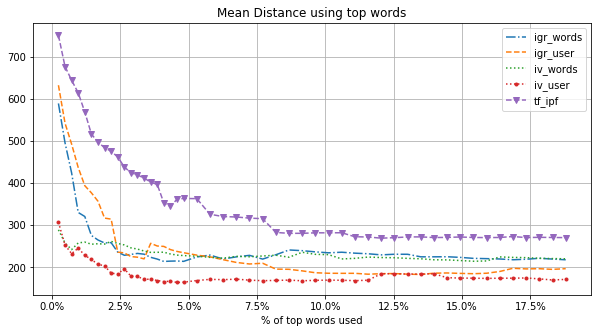

In [8]:
import matplotlib.pyplot as plt

cols = [col for col in joined.columns if "mean_distance" in col]
plot_df = joined[cols].copy()

rename = {col: rename_column(col) for col in cols}
plot_df.rename(rename, axis=1, inplace=True)


markers = ["-.", "--", ":", ":.", "--v"]
x = (100 * joined.index / word_df.shape[0])

ax = plot_df.plot(
    x=x,
    title="Mean Distance using top words", figsize=(10, 5), grid=True,
    style=markers,
);


ax.set_xlabel("% of top words used")
ax.set_ylabel("")
ax.set_xticklabels([str(t)+"%" for t in ax.get_xticks()]);

plt.savefig("../../output/figures/mean_distance_comparison.png")

El mismo patrón se repite acá. IV personas anda mucho mejor que el resto usando pocas palabras, pero después se empareja con IGR-personas